In [1]:
# Gaussians python script:
import math
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum as fgc
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

# Script to perform multiple Gaussian/Lorentzian/Voigt fits on the, single/double peak H-alpha line (on the blue, center and red peak)

file = np.loadtxt("smbxgpP201401200077_cr_cg_wr_01.txt") # smbxgpP201206270016_cr_cg_wr_01.txt smbxgpP201401200077_cr_cg_wr_01.txt smbxgpP202001120152_cr_cg_wr_01.txt
x = file[:,0]
y = file[:,1]


def func_gaus(x, *params): #Fitting function gaussian
    y = np.zeros_like(x)
    
    # y=np.zeros(len(x)*2)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)**2/wid**2))
    return y

def func_lorentzian(x, *params): #Fitting function lorentzian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * (0.5*wid**2/((x-ctr)**2+(0.5*wid)**2))
    return y

def func_voigt(x, *params): #Fitting function voigt

    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        gam = wid-1
        y = y + voigt_profile(x - ctr, wid, gam) * amp
    return y

# def find_double_peak_coords(x_data,y_data): #Function to find P_0 guess values for double peak plotting
    halpha_region_x = x_data[(x_data > 6540) & (x_data < 6590)]
    halpha_region_y = y_data[(x_data > 6540) & (x_data < 6590)]

    # print(halpha_region_x)

    peaks, props = find_peaks(halpha_region_y)
    # print(peaks)
    peak_wavelengths=halpha_region_x[peaks]
    peak_fluxes=halpha_region_y[peaks]
    # print("The peak Wl and fluxes: ",peak_wavelengths,peak_fluxes)
    
    valleys, props = find_peaks(-halpha_region_y)
    # print(valleys)
    valley_wavelength=halpha_region_x[valleys]
    valley_flux=halpha_region_y[valleys]
    # print(valley_wavelength,valley_flux)

    # --- Step 3: Pick the two largest peaks + the valley between
    # Sort peaks by flux
    sorted_peaks = np.argsort(peak_fluxes)[-2:]  # take top 2
    selected_peaks = [(peak_wavelengths[i], peak_fluxes[i]) for i in sorted_peaks]

    # For the dip, just take min flux between the two peaks
    left, right = np.min([p[0] for p in selected_peaks]), np.max([p[0] for p in selected_peaks])
    mask = (halpha_region_x > left) & (halpha_region_x < right)
    dip_idx = np.argmin(halpha_region_y[mask])
    dip_wavelength = halpha_region_x[mask][dip_idx]
    dip_flux = halpha_region_y[mask][dip_idx]

    # --- Print results ---
    print("Peaks (λ, flux):", selected_peaks)
    print("Dip (λ, flux):", (dip_wavelength, dip_flux))

    ctr1=math.trunc(selected_peaks[0][0]*10)
    amp1=math.trunc(selected_peaks[0][1]*10)
    wid1=6*10
    ctr2=valley_wavelength
    ctr2=math.trunc(ctr2[0]*10)
    wid2=0.5*((valley_wavelength-peak_wavelengths[0])+(peak_wavelengths[1]-valley_wavelength))
    wid2=math.trunc(3*10)
    ctr3=math.trunc(selected_peaks[1][0]*10)
    amp3=math.trunc(selected_peaks[1][1]*10)
    wid3=4*10
    amp2=dip_flux
    # amp2=-((amp1/10+amp3/10)/2-amp2)*5
    amp2=math.trunc(amp2*-0.76689539232*10)

    result=[ctr1/10,amp1/10,wid1/10,ctr2/10,amp2/8,wid2/10,ctr3/10,amp3/10,wid3/10]
    # result=[ctr1/10,amp1/10-1,wid1/10,ctr3/10,amp3/10-1,wid3/10]

    # if len(peaks)==1:
    #     # print(peak_wavelengths[0])
    #     ctr1=math.trunc(peak_wavelengths[0]*10)
    #     amp1=math.trunc(peak_fluxes[0]*10)
    #     wid1=13.0*10

    #     result=[ctr1/10,amp1/10-1,wid1/10]
    #     print(result)

    return result

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


def Smooth_find_double_peak_coords(x_data,y_data): #Function to find P_0 guess values for double or single peak plotting
    halpha_region_x = x_data[(x_data > 6555) & (x_data < 6570)]
    halpha_region_y = y_data[(x_data > 6555) & (x_data < 6570)]

    halpha_region_y=smooth(halpha_region_y,4)

    # print(halpha_region_x)

    peaks, props = find_peaks(halpha_region_y)
    print(peaks)
    peak_wavelengths=halpha_region_x[peaks]
    peak_fluxes=halpha_region_y[peaks]
    # print("The peak Wl and fluxes: ",peak_wavelengths,peak_fluxes)
    
    valleys, props = find_peaks(-halpha_region_y)
    # print(valleys)
    valley_wavelength=halpha_region_x[valleys]
    valley_flux=halpha_region_y[valleys]
    # print(valley_wavelength,valley_flux)
    if len(peaks)==2:
        # Sort peaks by flux
        sorted_peaks = np.argsort(peak_fluxes)[-2:]  # take top 2
        selected_peaks = [(peak_wavelengths[i], peak_fluxes[i]) for i in sorted_peaks]

        # For the valley, just take min flux between the two peaks
        left, right = np.min([p[0] for p in selected_peaks]), np.max([p[0] for p in selected_peaks])
        mask = (halpha_region_x > left) & (halpha_region_x < right)
        dip_idx = np.argmin(halpha_region_y[mask])
        dip_wavelength = halpha_region_x[mask][dip_idx]
        dip_flux = halpha_region_y[mask][dip_idx]

        print("Peaks (λ, flux):", selected_peaks)
        print("Valley (λ, flux):", (dip_wavelength, dip_flux))

        ctr1=math.trunc(selected_peaks[0][0]*10)
        amp1=math.trunc(selected_peaks[0][1]*10)
        wid1=6*10
        ctr2=dip_wavelength
        ctr2=math.trunc(ctr2*10)
        wid2=0.3*((dip_wavelength-peak_wavelengths[0])+(peak_wavelengths[1]-dip_wavelength))
        wid2=math.trunc(3*10)
        ctr3=math.trunc(selected_peaks[1][0]*10)
        amp3=math.trunc(selected_peaks[1][1]*10)
        wid3=4*10
        amp2=dip_flux
        # amp2=-((amp1/10+amp3/10)/2-amp2)*5
        amp2=math.trunc(amp2*0.76689539232*10)

        result=[ctr1/10,amp1/10,wid1/10,ctr2/10,amp2/10,wid2/10,ctr3/10,amp3/10,wid3/10]
        # result=[ctr1/10,amp1/10-1,wid1/10,ctr3/10,amp3/10-1,wid3/10]

    if len(peaks)==1:
        # print(peak_wavelengths[0])
        ctr1=math.trunc(peak_wavelengths[0]*10)
        amp1=math.trunc(peak_fluxes[0]*10)
        wid1=5.0*10

        result=[ctr1/10,amp1/10,wid1/10]
        print(result)

    return result

def spec_normalisation(x,y):
    ########### Function to normalise spectrum by dividing with fitted continuum (NTE this should only be done if imported data is not already normalised):
    s1_cal=y*u.Unit('erg cm-2 s-2 AA-1') #flux data
    wav_cal = x*u.AA #wavelength data

    spec=Spectrum1D(spectral_axis=wav_cal,flux=s1_cal)
    s_fit=fgc(spec,median_window=1)
    y_cont_fitted=s_fit(wav_cal)
    print(len(spec.spectral_axis.value))
    # print(find_double_peak_coords(spec.spectral_axis.value,(spec.flux/y_cont_fitted).value))


    fig=plt.figure(figsize=(8,5)) #create the figure
    # plt.yscale("log") #set y scale to log to correctly display the spectra
    plt.plot(spec.spectral_axis, spec.flux, label='spectra')
    plt.plot(wav_cal, y_cont_fitted, label='fitted continuum')
    plt.legend()
    plt.show()
    plt.close()

    #now plot normalised spectra
    fig=plt.figure(figsize=(8,5)) #create the figure

    plt.plot(spec.spectral_axis, spec.flux/y_cont_fitted, label='Normalized spectra')
    plt.legend()
    # plt.yscale("log") #set y scale to log to correctly display the spectra
    plt.show()
    plt.close()
    return spec.spectral_axis.value, (spec.flux/y_cont_fitted).value
    ###########


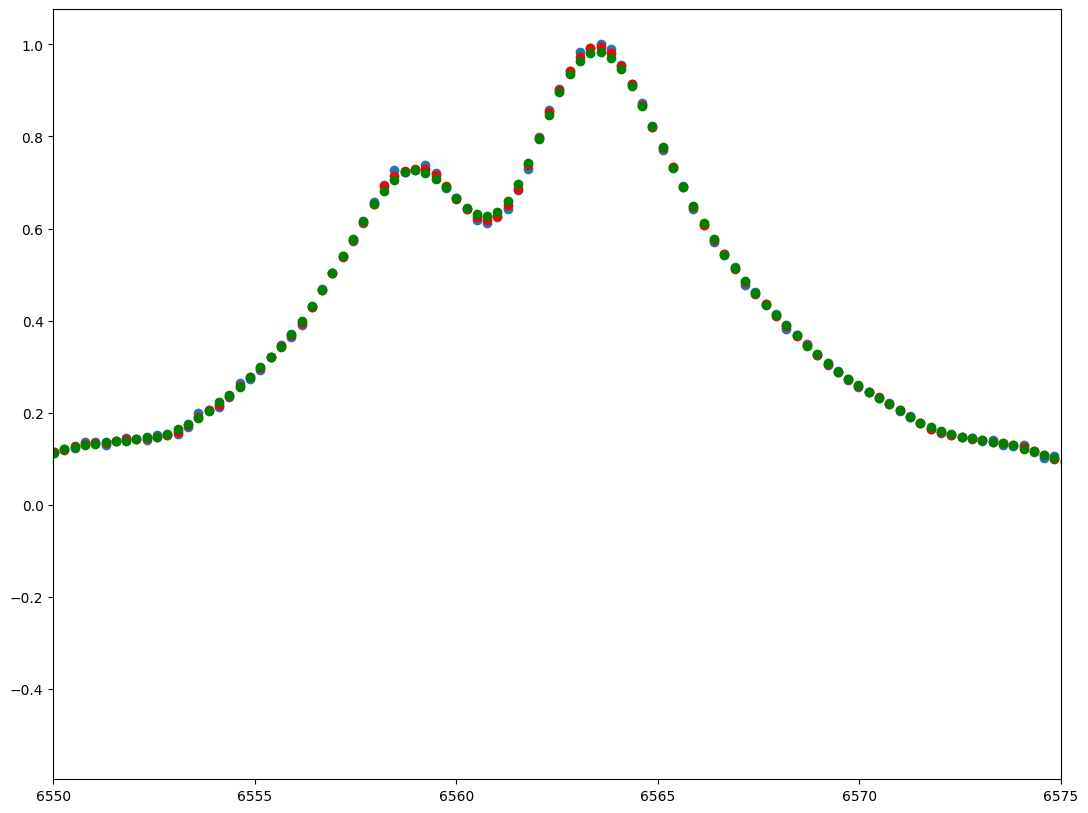

In [2]:
xmin,xmax = 6550,6575
graph_W,graph_H = 8,5

fig=plt.figure(figsize=(graph_W+5,graph_H+5))
plt.xlim(xmin,xmax)
plt.plot(x, y,'o')
# plt.show()
# plt.close()
plt.plot(x, smooth(y,3), 'ro', lw=2)
# plt.show()
# plt.close()
plt.plot(x, smooth(y,5), 'go', lw=1.5)
plt.show()
plt.close()

[15 33]
Peaks (λ, flux): [(6558.9763, 0.728835875), (6563.5832, 0.9910357999999999)]
Valley (λ, flux): (6560.7679, 0.62439645)
[6.56259656e+03 3.46709403e-01 1.22268797e+01 6.55838908e+03
 3.84488675e-01 2.01157828e+00 6.56372758e+03 6.14709320e-01
 2.90829680e+00]


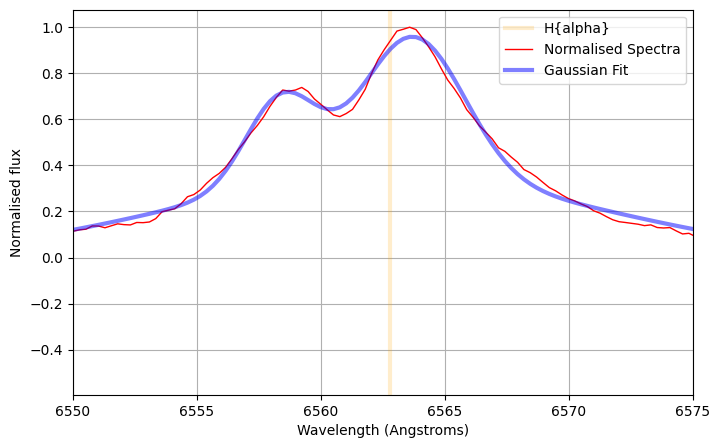

In [3]:
########### Gaussian fitting and plot:

# guess = [6555.0, 1.4, 6.0, 6561.0, -1.0, 3.0, 6565.0, 1.6, 4.0]
# guess = [6562.0, 1.0, 3.0]
# guess = find_double_peak_coords(spec.spectral_axis.value,(spec.flux/y_cont_fitted).value)
guess = Smooth_find_double_peak_coords(x,y)

    #for i in range(1):
#guess += [60+80*i, 46000, 25]


popt, pcov = curve_fit(func_gaus, x, y, p0=guess)
print(popt)
# fit_GAUS = func_gaus(spec.spectral_axis.value, *guess)
fit_GAUS = func_gaus(x, *popt)

########## Error analysis and inclusion in model (can be excluded to go straight to plot):
########## Need to find the correct way to get SALT errors on the y data.
# yerr_data= np.sqrt((spec.flux/y_cont_fitted).value)
# fig=plt.figure(figsize=(16, 9)) #create the figure
# plt.xlabel('Wavelength (Angstroms)')
# plt.ylabel('Normalised flux')
# plt.xlim(6520,6600)
# plt.errorbar(spec.spectral_axis.value, (spec.flux/y_cont_fitted).value, yerr_data, ls='', color='k')
# plt.scatter(spec.spectral_axis.value, (spec.flux/y_cont_fitted).value, s=7, zorder=1000)

fig=plt.figure(figsize=(graph_W,graph_H)) #create the figure
# plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Normalised flux')
plt.xlim(xmin,xmax)
plt.grid('minor')

plt.axvline(x = 6562.8, color = 'orange', linewidth=3, alpha=0.2, label='H{alpha}')
# plt.plot(spec.spectral_axis.value, (spec.flux/y_cont_fitted).value, 'r-', linewidth=1,label='Normalised Spectra')
plt.plot(x, y, 'r-', linewidth=1,label='Normalised Spectra')
# plt.plot(spec.spectral_axis.value, fit_GAUS, 'b-', linewidth=3, alpha=0.5,label='Gaussian Fit')
plt.plot(x, fit_GAUS, 'b-', linewidth=3, alpha=0.5,label='Gaussian Fit')

plt.legend()
#plt.show()
plt.savefig('Gaussian_demo.png')
###########



[6558.9, 0.7, 6.0, 6560.7, 0.4, 3.0, 6563.5, 0.9, 4.0]
[ 6.55815858e+03  2.19951381e-01  4.50546634e+00  6.56062662e+03
  6.17629576e-01 -1.26230227e-04  6.56383505e+03  4.39048122e-01
  7.07753757e+00]


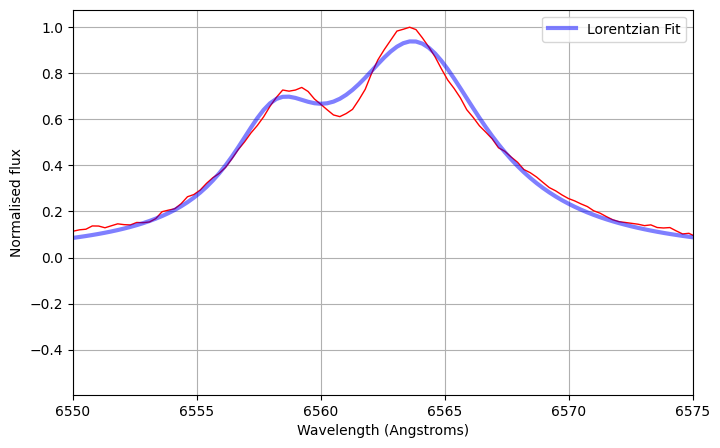

In [4]:
########### Lorentzian fitting and plot:
# guess = [6555, 1.4, 6.0, 6561.0, -1.1, 3.0, 6565.0, 1.6, 4.0]
# guess = find_double_peak_coords(spec.spectral_axis.value,(spec.flux/y_cont_fitted).value)
print(guess)
    #for i in range(1):
#guess += [60+80*i, 46000, 25]


popt, pcov = curve_fit(func_lorentzian, x, y, p0=guess)
print(popt)
fit_LORERTZIAN = func_lorentzian(x, *popt)

fig=plt.figure(figsize=(graph_W,graph_H)) #create the figure
# plt.yscale('log')
plt.grid('minor')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Normalised flux')
plt.xlim(xmin,xmax)
plt.plot(x, y, 'r-', linewidth=1)
plt.plot(x, fit_LORERTZIAN , 'b-', linewidth=3, alpha=0.5, label='Lorentzian Fit')
plt.legend()
#plt.show()
plt.savefig('Lorentzian_demo.png')
###########

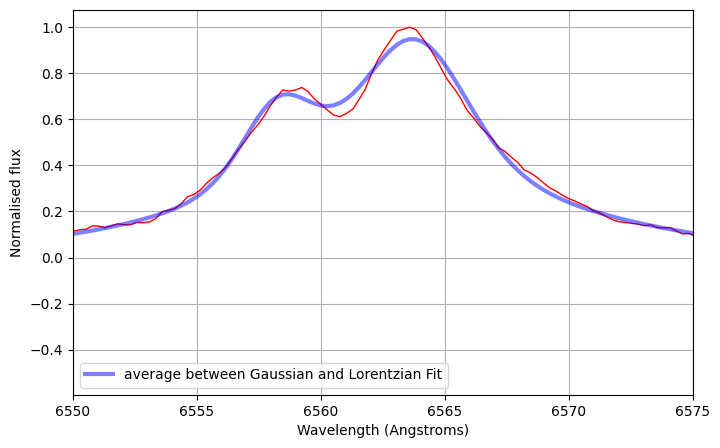

In [5]:
########### Agerage between GAUS and LORERNTZ fits, fitting and plot:

fit_AVG=(fit_GAUS+fit_LORERTZIAN)/2

fig=plt.figure(figsize=(graph_W,graph_H)) #create the figure
# plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Normalised flux')
plt.xlim(xmin,xmax)
plt.grid('minor')
plt.plot(x, y, 'r-', linewidth=1)
plt.plot(x, fit_AVG , 'b-', linewidth=3, alpha=0.5,label='average between Gaussian and Lorentzian Fit')
plt.legend()
#plt.show()
plt.savefig('Average_GAUS_LORENTZ_demo.png')
###########

[6558.9, 0.7, 6.0, 6560.7, 0.4, 3.0, 6563.5, 0.9, 4.0]
[6.55841099e+03 8.53491633e-01 1.15474037e+00 6.56253606e+03
 1.03814973e+01 4.31927110e+00 6.56374669e+03 1.68752979e+00
 1.30789881e+00]


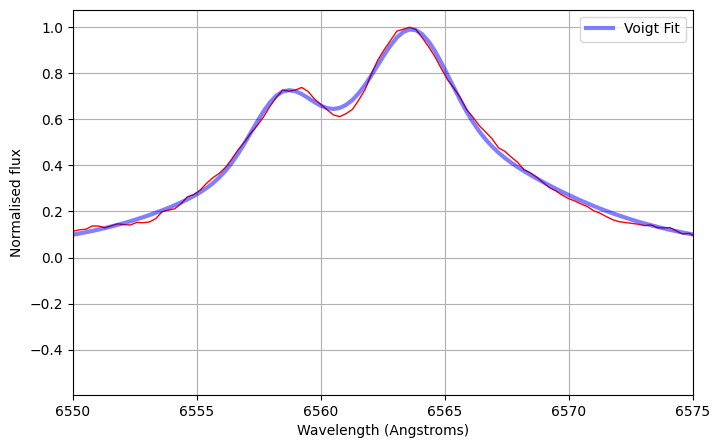

In [6]:
########### Voigt fitting and plot:

# guess = [6555, 1.4, 6.0, 6.0, 6565.0, 1.5, 4.0, 4.0]
# guess = find_double_peak_coords(x,y)
    #for i in range(1):
#guess += [60+80*i, 46000, 25]
print(guess)

popt, pcov = curve_fit(func_voigt, x, y, p0=guess)
print(popt)
fit_VOIGT = func_voigt(x, *popt)
# fit_VOIGT=np.convolve(fit_GAUS,fit_LORERTZIAN,mode='same')

fig=plt.figure(figsize=(graph_W,graph_H)) #create the figure
# plt.yscale('log')
plt.grid('minor')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Normalised flux')
plt.xlim(xmin,xmax)
plt.plot(x, y, 'r-', linewidth=1)
plt.plot(x, fit_VOIGT , 'b-', linewidth=3, alpha=0.5,label='Voigt Fit')
plt.legend()
#plt.show()
plt.savefig('Voigt_demo.png')
###########

[99.63686354 29.57537609  2.79050398  3.90880365 73.9226584  70.74399566
  3.18382538  2.96960336]


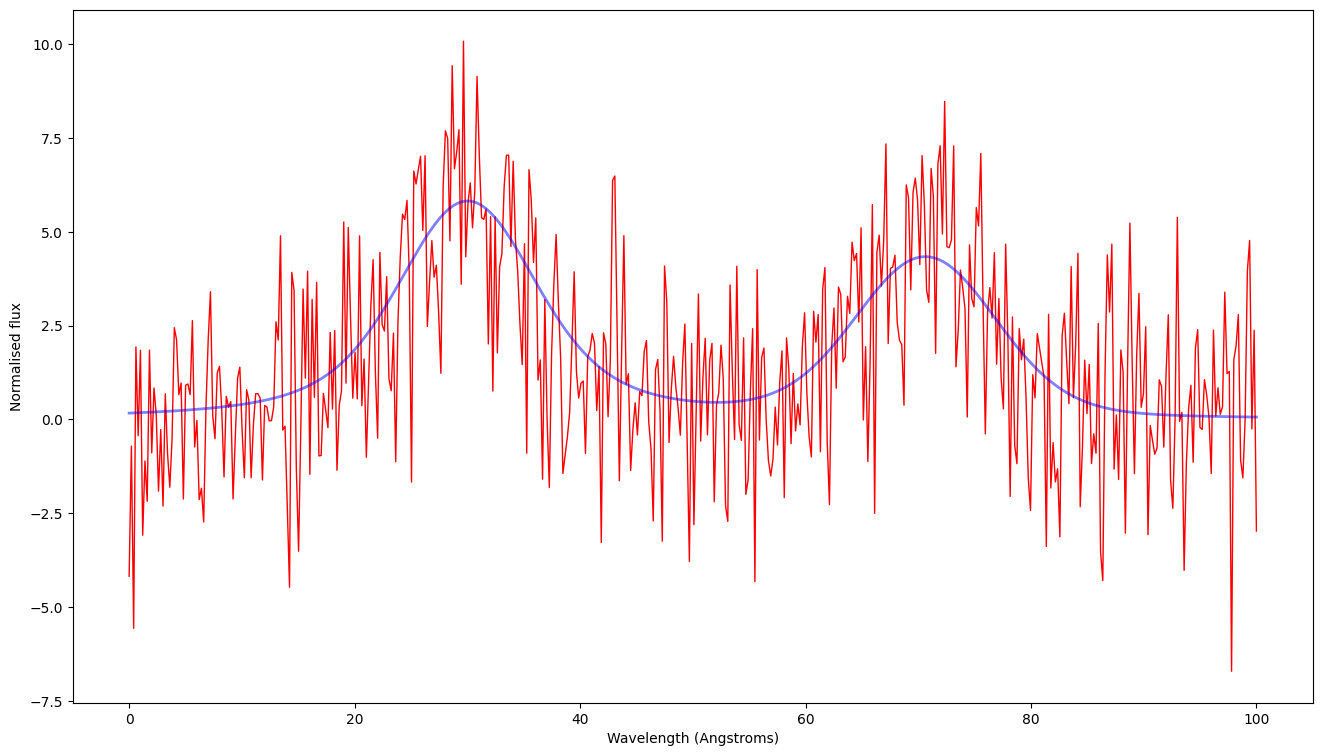

In [ ]:
import numpy as np
from scipy.optimize import curve_fit


def double_voigt(x, amp1, cen1, sig1, gam1, amp2, cen2, sig2, gam2):
    """
    A function representing the sum of two Voigt profiles.
    Parameters:
        x (array_like): The independent variable (e.g., wavelength, energy).
        amp1, cen1, sig1, gam1 (float): Parameters for the first Voigt profile.
        amp2, cen2, sig2, gam2 (float): Parameters for the second Voigt profile.
    Returns:
        array_like: The sum of two Voigt profiles at given x values.
    """
    return voigt_profile(x - cen1, sig1, gam1) * amp1 + \
           voigt_profile(x - cen2, sig2, gam2) * amp2

# Example usage with dummy data
# Replace with your actual x_data and y_data
x_data = np.linspace(0, 100, 500)
# Create some noisy double-peaked data for demonstration
y_data = (voigt_profile(x_data - 30, 5, 2) * 100 +
          voigt_profile(x_data - 70, 4, 3) * 70 +
          np.random.normal(0, 2, len(x_data)))

# Initial guesses for the 8 parameters
# (amp1, cen1, sig1, gam1, amp2, cen2, sig2, gam2)
initial_guesses = [90, 30, 5, 2, 60, 70, 4, 3]


popt, pcov = curve_fit(double_voigt, x_data, y_data, p0=initial_guesses)
print(popt)

fit = double_voigt(x_data, 113.90545215,  30.02391812,   4.34510307,   3.86406725,  71.52031152,  70.67003695,   5.77831164 ,  1.13183806)

fig=plt.figure(figsize=(16, 9)) #create the figure
# plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Normalised flux')
# plt.xlim(6520,6600)
plt.plot(x_data, y_data, 'r-', linewidth=1)
plt.plot(x_data, fit , 'b-', linewidth=2, alpha=0.5)
plt.show()

In [ ]:
# Areas python script:
from scipy.integrate import quad
import numpy as np
import pylab as pl
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
#This script calculates the blue and red surface areas and these are compared with the measured equivalent widths
#Equations A.17 and A.18

file = np.loadtxt('HR_ave_velocities.dat')
file2 = np.loadtxt('HR_ave_EW.dat')


MJD = file[:,0]
#cycles = file[:,1]
v_blue = file[:,2]
v_red = file[:,3]

EW_blue = file2[:,2]
EW_red = file2[:,3]

MJD_eph = 43366.275


def integrand(x,eccen):
    return 1.0/((1.0 + eccen*np.cos(x))**2)

ep = 0.4

#print I[0]

a_in = 1.0/(1.0 - ep)
inc = 0.52
v_crit = 525.0
degtorad = np.pi/180.0
radtodeg = 180.0/np.pi

g = open("HR_Areas_ave_out.txt","w")
for i in range(len(MJD)):
    t1 = ((2.0*v_crit)/(v_red[i] - v_blue[i]))**2
    t2 = ((np.sin(inc))**2)/(1.0 - ep**2)
    a_p = t1*t2
    ts1 = 0.5*(a_p**2 - a_in**2)*(1.0 - ep**2)*np.cos(inc)
    MJD_conv = MJD[i] - 2400000.5
    ratio = ((v_red[i]+v_blue[i])/(v_red[i]-v_blue[i]))
    om = np.arccos(ratio*(1.0/ep))
    cos_om = ratio*(1.0/ep)
    f01 = np.arccos(-ep*cos_om) - om
    f01_deg = f01*radtodeg
    
    f02 = (2.0*np.pi - np.arccos(-ep*cos_om)) - om
    f02_deg = f02*radtodeg
    
    
    I_b = quad(integrand,f01,f02,args=(ep))
    ts2 = I_b[0]
    S_blue = ts1*ts2
    I_r = quad(integrand,f02,f01+2.0*np.pi,args=(ep))
    ts3 = I_r[0]
    S_red = ts1*ts3
    ratio_areas = S_blue/S_red
    ratio_EW = EW_blue[i]/EW_red[i]
    g.write("%0.3f  %0.3f   %0.3f   %0.3f   %0.3f   %0.3f   %0.3f   %0.3f   %0.3f   %0.3f   %0.3f\n" %(MJD[i],S_blue,S_red,EW_blue[i],EW_red[i],ratio_areas,ratio_EW,I_b[0],I_r[0],f01_deg,f02_deg))
g.close()




In [33]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def map_DEG_to_RA(deg_list):
    RA_list=[]
    coord=0
    for i in range(0,len(deg_list)):
        hour= (deg_list[i]//1)*(1/15) #get the integer part of the float degree value and convert to hours. (1/15 hours per degree)
        minute= (hour-hour//1)*4.0 #decimal part of the degree float converted to minutes (4 minutes per degree)
        second= (minute-minute//1)*60 #decimal part of the minute coordinate, converted to seconds coordinate (60 sec per minute)
        coord=hour//1+(minute//1)/100+((second//1)//1)/10000
        RA_list.append(coord)
    return(RA_list)

print(map_DEG_to_RA([22.2565,23]))

[1.0151000000000001, 1.0207]


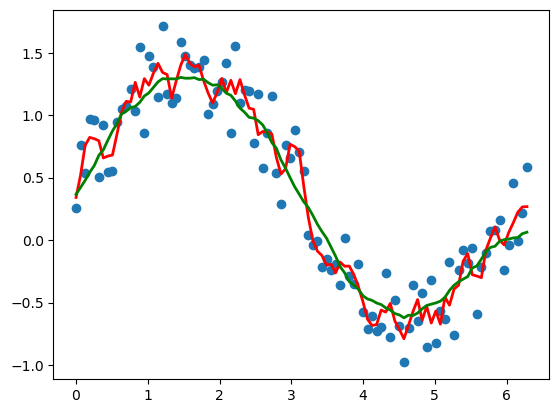

In [11]:
#Smoothing code
x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.8

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.plot(x, y,'o')
# plt.show()
# plt.close()
plt.plot(x, smooth(y,3), 'r-', lw=2)
# plt.show()
# plt.close()
plt.plot(x, smooth(y,19), 'g-', lw=2)
plt.show()
plt.close()